#**![__results___29_0.png](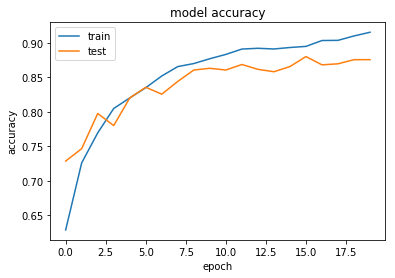![__results___29_0.png](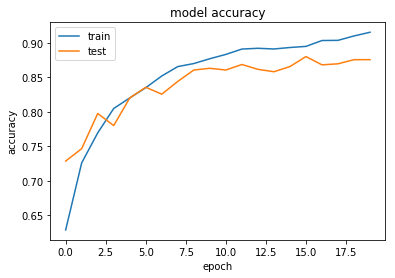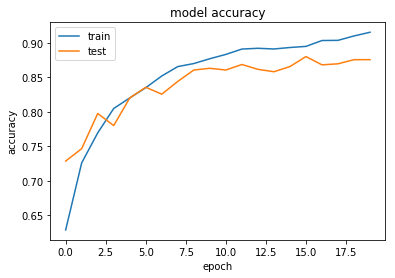))Importing the libraries**

In [92]:
import pandas as pd
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

import seaborn as sns

from tqdm import tqdm
import os


In [93]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bhanu23","key":"116fed1e0d4820acb1dbd70da849f80d"}'}

In [94]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [95]:
!kaggle competitions download -c airbus-ship-detection

airbus-ship-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [96]:
import zipfile
zip_ref = zipfile.ZipFile('airbus-ship-detection.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

KeyboardInterrupt: 

#**Data preperation and preprocessing**





1. Feature engineering

In [162]:
# Initialize global variables
SAMPLE_SIZE = 10000
BATCH_SIZE = 32
TEST_PERC = 0.2

In [163]:
segmentations = pd.read_csv("/content/train_ship_segmentations_v2.csv")

Adding a new column to the dataframe which will give the paths to each image in the dataframe

In [164]:
segmentations['path'] = '../content/train_v2/' + segmentations['ImageId']
segmentations.shape

(231723, 3)

In [165]:
segmentations = segmentations.sample(n=SAMPLE_SIZE)

In [166]:
def has_ship(encoded_pixels):
    hs = [0 if pd.isna(n) else 1 for n in tqdm(encoded_pixels)]
    return hs

In [167]:
segmentations['HasShip'] = has_ship(segmentations['EncodedPixels'].values)
segmentations['HasShip'].head()

100%|██████████| 10000/10000 [00:00<00:00, 784143.28it/s]


53904     1
179671    1
60372     0
204226    1
189758    0
Name: HasShip, dtype: int64

In [168]:
segmentations.head()

,ImageId,EncodedPixels,path,HasShip
53904,3be920da9.jpg,228187 1 228954 4 229722 6 230489 8 231257 10 ...,../content/train_v2/3be920da9.jpg,1
179671,c66eb97bc.jpg,515097 1 515864 4 516632 5 517399 8 518167 9 5...,../content/train_v2/c66eb97bc.jpg,1
60372,42e2c56ef.jpg,NaN,../content/train_v2/42e2c56ef.jpg,0
204226,e1cf5aa4d.jpg,124267 1 125035 3 125802 5 126570 6 127337 9 1...,../content/train_v2/e1cf5aa4d.jpg,1
189758,d1d7662b0.jpg,NaN,../content/train_v2/d1d7662b0.jpg,0


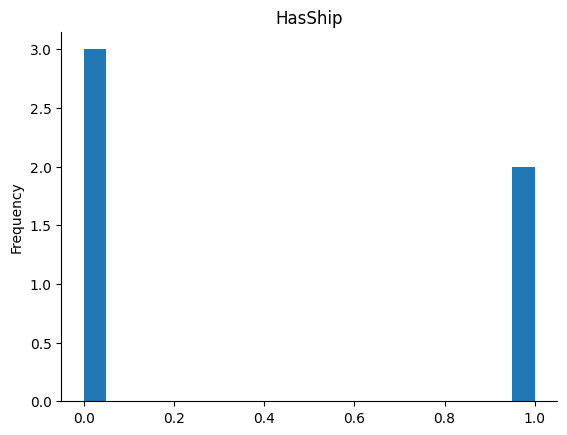

In [169]:
from matplotlib import pyplot as plt
_df_0['HasShip'].plot(kind='hist', bins=20, title='HasShip')
plt.gca().spines[['top', 'right',]].set_visible(False)

2. Image preprocessing

In [170]:
segmentations.head()

,ImageId,EncodedPixels,path,HasShip
53904,3be920da9.jpg,228187 1 228954 4 229722 6 230489 8 231257 10 ...,../content/train_v2/3be920da9.jpg,1
179671,c66eb97bc.jpg,515097 1 515864 4 516632 5 517399 8 518167 9 5...,../content/train_v2/c66eb97bc.jpg,1
60372,42e2c56ef.jpg,NaN,../content/train_v2/42e2c56ef.jpg,0
204226,e1cf5aa4d.jpg,124267 1 125035 3 125802 5 126570 6 127337 9 1...,../content/train_v2/e1cf5aa4d.jpg,1
189758,d1d7662b0.jpg,NaN,../content/train_v2/d1d7662b0.jpg,0


In [171]:
np.shape(load_img(segmentations['path'].values[0]))

(768, 768, 3)

In [172]:
train,test = train_test_split(segmentations, test_size=TEST_PERC)

In [173]:
idg_train = ImageDataGenerator(rescale=1. / 255,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True)

idg_test = ImageDataGenerator(rescale=1. / 255)

In [192]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    df_gen = img_data_gen.flow_from_directory(base_dir,
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen




In [193]:
train_images = flow_from_dataframe(idg_train, train, 'path', 'HasShip', batch_size=BATCH_SIZE, target_size=(256, 256))
test_images = flow_from_dataframe(idg_train, test, 'path', 'HasShip', batch_size=BATCH_SIZE, target_size=(256, 256))
# train_images = flow_from_dataframe(idg_train, train, 'path', 'HasShip', batch_size=BATCH_SIZE, target_size=(256, 256))
# test_images = flow_from_dataframe(idg_test, test, 'path', 'HasShip', batch_size=BATCH_SIZE, target_size=(256, 256))


Found 0 images belonging to 0 classes.
Reinserting dataframe: 8000 images
Found 0 images belonging to 0 classes.
Reinserting dataframe: 2000 images


In [194]:
train_images.target_size

(256, 256)

#**Creating the NN Model**

Input -> 3 Convolutional and Max Pooling Layers -> Fully connected ANN with 2 hidden layers

In [195]:
model = Sequential()
model.add(Convolution2D(32, (3, 3),
                       input_shape=(256, 256, 3),
                       activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3),
                       input_shape=(256, 256, 3),
                       activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3),
                       input_shape=(256, 256, 3),
                       activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(units=128, activation='relu', kernel_initializer='normal'))
model.add(Dense(units=1, activation='sigmoid', kernel_initializer='normal'))

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 30, 30, 32)       

In [ ]:
fitted_model = model.fit(train_images,
                   steps_per_epoch=SAMPLE_SIZE*(1-TEST_PERC)/BATCH_SIZE,
                   epochs=20,
                   validation_data=test_images,
                   validation_steps=SAMPLE_SIZE*(TEST_PERC)/BATCH_SIZE)

>Epoch 1/20



>250/250 [==============================] - 297s 1s/step - loss: 0.6283 - acc: 0.6288 - val_loss: 0.5562 - val_acc: 0.7285
Epoch 2/20
250/250 [==============================] - 274s 1s/step - loss: 0.5550 - acc: 0.7259 - val_loss: 0.5304 - val_acc: 0.7465
Epoch 3/20
250/250 [==============================] - 279s 1s/step - loss: 0.4871 - acc: 0.7694 - val_loss: 0.4418 - val_acc: 0.7975
Epoch 4/20
250/250 [==============================] - 275s 1s/step - loss: 0.4384 - acc: 0.8048 - val_loss: 0.4577 - val_acc: 0.7800
Epoch 5/20
250/250 [==============================] - 270s 1s/step - loss: 0.4155 - acc: 0.8200 - val_loss: 0.4141 - val_acc: 0.8200
Epoch 6/20
250/250 [==============================] - 274s 1s/step - loss: 0.3913 - acc: 0.8349 - val_loss: 0.3881 - val_acc: 0.8355
Epoch 7/20
250/250 [==============================] - 271s 1s/step - loss: 0.3545 - acc: 0.8519 - val_loss: 0.4034 - val_acc: 0.8255
Epoch 8/20
250/250 [==============================] - 271s 1s/step - loss: 0.3381 - acc: 0.8655 - val_loss: 0.3880 - val_acc: 0.8440
Epoch 9/20
250/250 [==============================] - 270s 1s/step - loss: 0.3248 - acc: 0.8699 - val_loss: 0.3677 - val_acc: 0.8605
Epoch 10/20
250/250 [==============================] - 267s 1s/step - loss: 0.3003 - acc: 0.8769 - val_loss: 0.3558 - val_acc: 0.8630
Epoch 11/20
250/250 [==============================] - 267s 1s/step - loss: 0.2902 - acc: 0.8831 - val_loss: 0.3651 - val_acc: 0.8605
Epoch 12/20
250/250 [==============================] - 268s 1s/step - loss: 0.2788 - acc: 0.8909 - val_loss: 0.3443 - val_acc: 0.8685
Epoch 13/20
250/250 [==============================] - 266s 1s/step - loss: 0.2773 - acc: 0.8920 - val_loss: 0.3547 - val_acc: 0.8615
Epoch 14/20
250/250 [==============================] - 267s 1s/step - loss: 0.2775 - acc: 0.8910 - val_loss: 0.3789 - val_acc: 0.8580
Epoch 15/20
250/250 [==============================] - 268s 1s/step - loss: 0.2715 - acc: 0.8931 - val_loss: 0.3804 - val_acc: 0.8655
Epoch 16/20
250/250 [==============================] - 268s 1s/step - loss: 0.2620 - acc: 0.8947 - val_loss: 0.3419 - val_acc: 0.8800
Epoch 17/20
250/250 [==============================] - 266s 1s/step - loss: 0.2508 - acc: 0.9033 - val_loss: 0.3588 - val_acc: 0.8680
Epoch 18/20
250/250 [==============================] - 269s 1s/step - loss: 0.2521 - acc: 0.9035 - val_loss: 0.3605 - val_acc: 0.8695
Epoch 19/20
250/250 [==============================] - 267s 1s/step - loss: 0.2383 - acc: 0.9099 - val_loss: 0.3717 - val_acc: 0.8755
Epoch 20/20
250/250 [==============================] - 264s 1s/step - loss: 0.2269 - acc: 0.9152 - val_loss: 0.3793 - val_acc: 0.8755


Plot of Accuracy and Loss history of our model for both train and validation sets

In [ ]:
import matplotlib.pyplot as plt
import pylab


path = 'results'
name = 'adam'

plt.plot(fitted_model.history['acc'])
plt.plot(fitted_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()



> ![picture](https://drive.google.com/uc?export=view&id=1px18-1c5BnOurXsM03-O7p_0M8k9voLB)




In [ ]:
plt.figure()
plt.gcf().clear()
plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()


> ![picture](https://drive.google.com/uc?export=view&id=1ZVvMeAsQhA3lnlo5dB4oN4d9MHUMnKz3)


